# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 2.6 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.7 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 3.5 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install pandas scikit-learn torch scarf

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached hnswlib-0.8.0.tar.gz (36 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached loguru-0.7.2-py3-none-any.whl.metadata (23 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached igraph-0.11.8-cp39-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cache

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

# sys.path.append("../")

# sys.path.append(os.path.abspath("../"))
# sys.path.append("/Users/hemantyadav/Documents/DeepLearningProject/SCARF_Implementation/pytorch-scarf/scarf")

from loss import NTXent
from loss import FairNTXent
from model import SCARF
from dataset import SCARFDataset
from biasAware import BiasDetectionPreprocessor
from biasAware import Encoder
from biasAware import AdversarialDebiasingNetwork

from utils import get_device, dataset_embeddings, fix_seed, train_epoch

seed = 1234
fix_seed(seed)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [3]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, stratify=target, random_state=seed
)

# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# to torch dataset
train_ds = SCARFDataset(train_data.to_numpy(), train_target.to_numpy(), columns=train_data.columns)
test_ds = SCARFDataset(test_data.to_numpy(), test_data.to_numpy(), columns=test_data.columns)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")

Train set: (455, 30)
Test set: (114, 30)


# Training

Text(0, 0.5, 'loss')

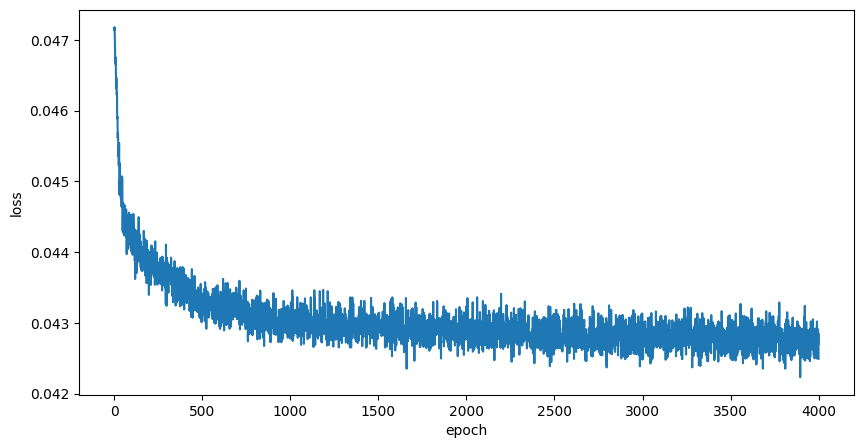

In [5]:
batch_size = 128
epochs = 4000
device = get_device()

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=8,
    num_hidden_encoder=3,
    dim_hidden_head=24,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}", end="\r")


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

### Improved Training Bias_Awareness:

Text(0, 0.5, 'loss')

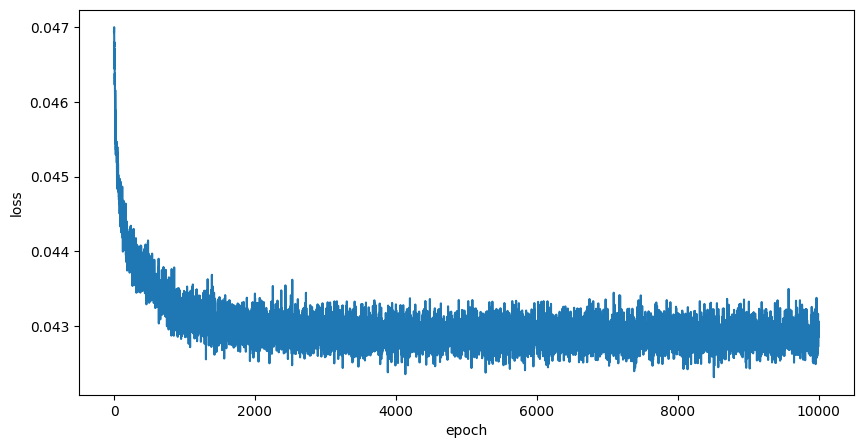

In [7]:
# Training Configuration
sensitive_attributes = ['age', 'gender']
preprocessor = BiasDetectionPreprocessor(sensitive_attributes)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
device = get_device()

# Model Initialization
encoder = Encoder(input_dim=train_ds.shape[1], hidden_dim=8, num_layers=3).to(device)
adv_debiasing_net = AdversarialDebiasingNetwork(input_dim=8, hidden_dim=8, num_layers=2, num_sensitive_features=len(sensitive_attributes.unique())).to(device)

optimizer = Adam(list(encoder.parameters()), lr=1e-3, weight_decay=1e-5)
adv_optimizer = Adam(adv_debiasing_net.parameters(), lr=1e-4, weight_decay=1e-5)
fair_ntxent_loss = FairNTXent(temperature=1.0, lambda_reg=0.1)

# Training Loop
for epoch in range(1, 2001):
    for x, _ in train_loader:
        x = x.to(device)
        z_i, z_j = encoder(x), encoder(x)  # Representations for original and corrupted views

        # Fairness-aware NT-Xent loss with sensitive features
        loss = fair_ntxent_loss(z_i, z_j, sensitive_attributes)
        
        # Encoder update
        optimizer.zero_grad()
        loss.backward(retain_graph=True)  # Retain graph for adversarial training
        optimizer.step()

        # Adversarial Debiasing step
        adv_optimizer.zero_grad()
        adv_loss = F.cross_entropy(adv_debiasing_net(z_i.detach()), sensitive_attributes.to(device))  # Predict sensitive features
        adv_loss.backward()
        adv_optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/2000], Loss: {loss.item():.4f}")


# Evaluate embeddings

In [8]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

(455, 8)
(114, 8)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



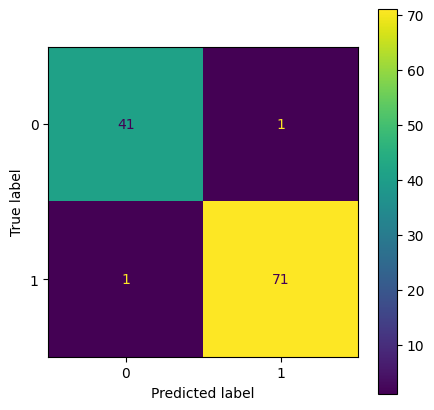

In [9]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
vanilla_predictions = clf.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



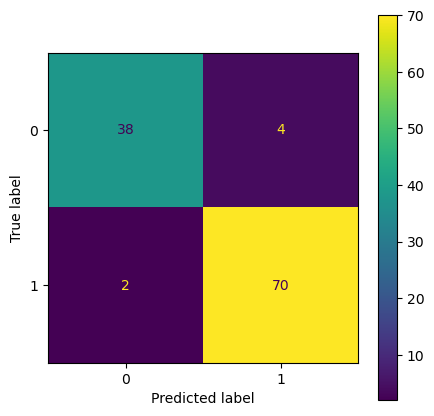

In [12]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# Visualzie using t-sne 

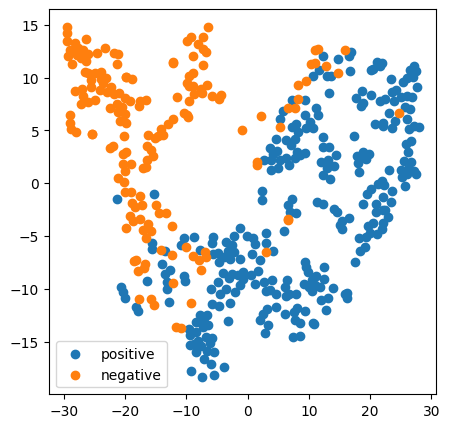

In [10]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()